In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = 'cpu'
from torchdiffeq import odeint

In [44]:
def FN_torch(t, V, a=0.2, b=0.2, c=3.0):
    return torch.hstack((c * (V[0] - V[0]**3/3 + V[1]), -1/c * (V[0] - a + b*V[1])))

def FN_torch_modified(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.hstack((V1, V2))
    terms = torch.tensor([V[0]**2, V[1]**2])
    dV += torch.matmul(eta, terms)
    return dV

def FN_torch_vec(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[:,0] - V[:,0]**3/3 + V[:,1])
    V2 = -1/c * (V[:,0] - a + b*V[:,1])
    dV = torch.vstack((V1, V2))
    terms = torch.vstack([V[:,0]**2, V[:,1]**2])
    m = torch.matmul(eta, terms)
    dV = dV + m
#     print(dV.shape)
    return dV.T

def FN_torch_modified_large(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.hstack((V1, V2))
    terms = torch.tensor([V[0]**2, V[1]**2, V[0]*V[1], V[0]**2*V[1], V[0]*V[1]**2, torch.exp(V[0]), torch.exp(V[1]), V[0]**4, V[0]**3*V[1], V[0]**2*V[1]**2, V[0]*V[1]**3, V[1]**4])
    dV += torch.matmul(eta, terms)
    return dV 

In [50]:
def make_predictions(t, x_true, optfitz):
#     print(optfitz.forward(t, x_true)[:,:].shape)
    
    return optfitz.forward(t, x_true)[:-1,:]

In [36]:
class DiffLoss(torch.nn.Module):
    
    def __init__(self):
        super(DiffLoss, self).__init__()
        
    def forward(self, a, b):
        
        a_diff = torch.diff(a, axis=0)
        b_diff = torch.diff(b, axis=0)
        
        return torch.mean((a_diff - b_diff)**2)

In [37]:
class OptimizeFitzhugh(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhugh, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_vec(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

In [26]:
class OptimizeFitzhughLarge(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhughLarge, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_modified_large(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

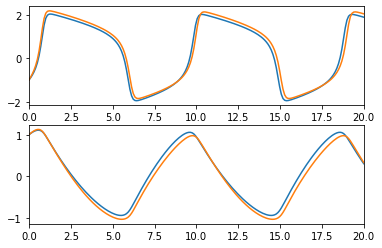

In [27]:
true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)

fn_true = lambda t, x : FN_torch_modified(t, x, true_eta)

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
soln = odeint(fn_true, x0, t_space)

soln_unpert = odeint(FN_torch, x0, t_space)

ax1 = plt.subplot(211)
ax1.set_xlim(0,ub)
plt.plot(t_space, soln_unpert[:,0])
plt.plot(t_space, soln[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, soln_unpert[:,1])
plt.plot(t_space, soln[:,1])
plt.show()

In [99]:
eta_method = 'random'
check_grads = False
max_it = 10000

N = 20000
ub = 200

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-4


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.1, (2,2)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2,2)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

print(eta0)

with torch.no_grad():
    true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
    true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)
    true_diff = torch.diff(true_soln, axis=0)


optfitz = OptimizeFitzhugh(x0, t_space, 2, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-2)
# loss = DiffLoss().to(device)
loss = torch.nn.MSELoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

#     pred_soln = odeint(optfitz, x0, t_space).to(device)
    pred_diff = make_predictions(t_space, true_soln, optfitz).to(device)
    
    loss_curr = loss(pred_diff, true_diff)
    loss_curr.retain_grad()
    loss_curr.backward()

    if check_grads:
        if it > 0:
            for i in range(optfitz.eta.shape[0]):
                for j in range(optfitz.eta.shape[1]):
                    print('Backprop Derivative for {},{} = {:.2f}'.format(i, j, optfitz.eta.grad[i,j]))
                    print('Checked Derivative for {},{} = {:.2f}'.format(i, j, grad_check[i,j]))
                    # print('Error Ratio = {:.2f}'.format(optfitz.eta.grad[i,j] / grad_check[i,j]))
                    print()
        print('\n')

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        if not (eta_method == 'actual' and it < 1):
            break

    print(optfitz.eta.grad)
    loss_vec.append(loss_curr.detach().numpy())

    if check_grads:

        print('===Derivative Check===')

        grad_check = np.zeros((optfitz.eta.shape[0], optfitz.eta.shape[1]))
        for i in range(optfitz.eta.shape[0]):
            for j in range(optfitz.eta.shape[1]):
                eps = 10**(-3)
                eta_check_0 = optfitz.eta.detach().clone()
                eta_check_1 = optfitz.eta.detach().clone()

                eta_check_0[i,j] += eps
                eta_check_1[i,j] -= eps

                FN_check_0 = lambda t, S : FN_torch_modified(t, S, eta_check_0)
                x_pred_check_0 = odeint(FN_check_0, x0, t_space)
                FN_check_1 = lambda t, S : FN_torch_modified(t, S, eta_check_1)
                x_pred_check_1 = odeint(FN_check_1, x0, t_space)

                L0 = loss(x_pred_check_0, true_soln)
                L1 = loss(x_pred_check_1, true_soln)
                grad_check[i,j] = ((L0 - L1)/(2*eps)).item()

    optimizer.step()


tensor([[ 0.1129, -0.1101],
        [ 0.2308,  0.0236]])
eta_0 = 
[[ 0.1129 -0.1101]
 [ 0.2308  0.0236]]

Iterarion 1
eta = 
[[ 0.1129 -0.1101]
 [ 0.2308  0.0236]]
loss = 1.4425


tensor([[-1.3311, -0.1762],
        [ 1.3089,  0.1511]])
Iterarion 2
eta = 
[[ 0.1229 -0.1001]
 [ 0.2208  0.0136]]
loss = 1.4137


tensor([[-1.2561, -0.1657],
        [ 1.2340,  0.1406]])
Iterarion 3
eta = 
[[ 0.1329 -0.0901]
 [ 0.2108  0.0036]]
loss = 1.3866


tensor([[-1.1813, -0.1552],
        [ 1.1591,  0.1301]])
Iterarion 4
eta = 
[[ 0.1429 -0.0802]
 [ 0.2008 -0.0063]]
loss = 1.3614


tensor([[-1.1067, -0.1447],
        [ 1.0846,  0.1197]])
Iterarion 5
eta = 
[[ 0.1528 -0.0703]
 [ 0.1909 -0.0161]]
loss = 1.3379


tensor([[-1.0325, -0.1343],
        [ 1.0104,  0.1093]])
Iterarion 6
eta = 
[[ 0.1626 -0.0605]
 [ 0.1811 -0.0259]]
loss = 1.3163


tensor([[-0.9589, -0.1240],
        [ 0.9368,  0.0989]])
Iterarion 7
eta = 
[[ 0.1723 -0.0508]
 [ 0.1714 -0.0356]]
loss = 1.2965


tensor([[-0.8858, -0.1137],
      

Iterarion 93
eta = 
[[ 0.2955  0.0295]
 [ 0.0432 -0.0322]]
loss = 1.1829


tensor([[ 7.4077e-03,  8.1880e-04],
        [-5.0736e-03,  2.5239e-05]])
Iterarion 94
eta = 
[[ 0.2953  0.0294]
 [ 0.0434 -0.0321]]
loss = 1.1829


tensor([[ 0.0060,  0.0006],
        [-0.0036,  0.0002]])
Iterarion 95
eta = 
[[ 0.2951  0.0292]
 [ 0.0436 -0.032 ]]
loss = 1.1829


tensor([[ 0.0045,  0.0004],
        [-0.0021,  0.0004]])
Iterarion 96
eta = 
[[ 0.2949  0.029 ]
 [ 0.0438 -0.0319]]
loss = 1.1829


tensor([[ 0.0031,  0.0002],
        [-0.0008,  0.0005]])
Iterarion 97
eta = 
[[ 0.2947  0.0288]
 [ 0.0439 -0.0319]]
loss = 1.1829


tensor([[1.7905e-03, 3.3978e-05],
        [4.4277e-04, 6.7746e-04]])
Iterarion 98
eta = 
[[ 0.2946  0.0287]
 [ 0.0441 -0.0319]]
loss = 1.1829


tensor([[ 0.0006, -0.0001],
        [ 0.0015,  0.0008]])
Iterarion 99
eta = 
[[ 0.2944  0.0285]
 [ 0.0442 -0.0319]]
loss = 1.1829


tensor([[-0.0006, -0.0003],
        [ 0.0025,  0.0009]])
Iterarion 100
eta = 
[[ 0.2943  0.0284]
 [ 0.044

Iterarion 167
eta = 
[[ 0.2944  0.0294]
 [ 0.0441 -0.0342]]
loss = 1.1829


tensor([[ 2.1564e-04,  3.4272e-05],
        [-2.1459e-04, -2.3374e-05]])
Iterarion 168
eta = 
[[ 0.2944  0.0294]
 [ 0.0441 -0.0342]]
loss = 1.1829


tensor([[ 2.1257e-04,  3.3307e-05],
        [-1.9176e-04, -1.9379e-05]])
Iterarion 169
eta = 
[[ 0.2944  0.0294]
 [ 0.0441 -0.0341]]
loss = 1.1829


tensor([[ 2.0374e-04,  3.1546e-05],
        [-1.6553e-04, -1.5010e-05]])
Iterarion 170
eta = 
[[ 0.2944  0.0294]
 [ 0.0441 -0.0341]]
loss = 1.1829


tensor([[ 1.8980e-04,  2.9080e-05],
        [-1.3700e-04, -1.0428e-05]])
Iterarion 171
eta = 
[[ 0.2944  0.0294]
 [ 0.0441 -0.0341]]
loss = 1.1829


tensor([[ 1.7146e-04,  2.6031e-05],
        [-1.0731e-04, -5.7849e-06]])
Iterarion 172
eta = 
[[ 0.2944  0.0294]
 [ 0.0441 -0.0341]]
loss = 1.1829


tensor([[ 1.4982e-04,  2.2520e-05],
        [-7.7446e-05, -1.2240e-06]])
Iterarion 173
eta = 
[[ 0.2944  0.0294]
 [ 0.0441 -0.0341]]
loss = 1.1829


tensor([[ 1.2602e-04,  1.8717e

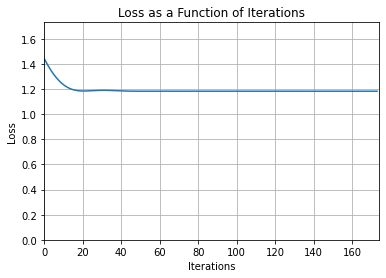

In [100]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec)), loss_vec)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Loss as a Function of Iterations')
ax.set_xlim((0, len(loss_vec)))
ax.set_ylim((0, max(loss_vec) * 1.2))
plt.grid()
plt.show()

tensor([[ 0.2944,  0.0294],
        [ 0.0441, -0.0341]])


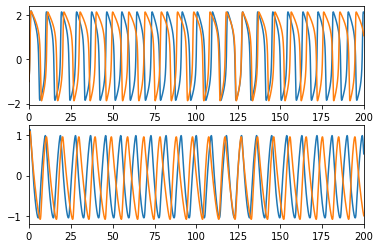

In [101]:
eta_found = optfitz.eta.detach()
fn_found = lambda t, x : FN_torch_modified(t, x, eta_found)
# fn_found = lambda t, x : FN_torch_modified(t, x, torch.zeros((2,2)))

print(eta_found)

found_soln = odeint(fn_found, x0, t_space)

ax1 = plt.subplot(211)
ax1.set_xlim(0,ub)
plt.plot(t_space, true_soln[:,0])
plt.plot(t_space, found_soln.detach()[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, true_soln[:,1])
plt.plot(t_space, found_soln.detach()[:,1])
plt.show()

In [ ]:
tensor([[ 0.3285, -0.4670],
        [ 0.0596, -0.0284]])

tensor([[ 0.3285, -0.4670],
        [ 0.0596, -0.0284]])

tensor([[ 0.3278, -0.4624],
        [ 0.0596, -0.0284]])

tensor([[ 0.2944,  0.0294],
        [ 0.0441, -0.0341]])

eta = 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0005, 0.0000, 0.0500, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])


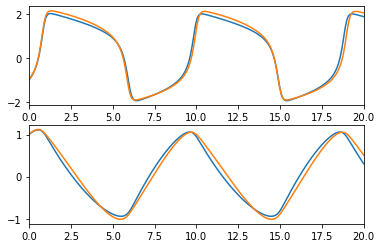

In [171]:
n_basis = 12

true_eta = torch.zeros((2,n_basis), dtype=torch.float)
non_zero = np.random.choice(range(2*n_basis), 3, replace=False)
for ix in non_zero:
    i = int(ix/n_basis)
    j = int(ix)%n_basis
    if j == 5 or j == 6:
        true_eta[i,j] += 0.0005
    else:
        true_eta[i,j] += 0.05
    
# true_eta = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0.05,0], [0,0.05,0,0,0,0.005,0,0,0,0,0,0]], dtype=torch.float)

print('eta = \n{}'.format(true_eta))

fn_true = lambda t, x : FN_torch_modified_large(t, x, true_eta)

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
soln = odeint(fn_true, x0, t_space)

soln_unpert = odeint(FN_torch, x0, t_space)

ax1 = plt.subplot(211)
ax1.set_xlim(0,ub)
plt.plot(t_space, soln_unpert[:,0])
plt.plot(t_space, soln[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, soln_unpert[:,1])
plt.plot(t_space, soln[:,1])
plt.show()

In [56]:
eta_method = 'random'
check_grads = False
max_it = 1000

N = 200
ub = 20
n_basis = 12

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-4

true_eta = torch.zeros((2,n_basis), dtype=torch.float)
non_zero = np.random.choice(range(2*n_basis), 3, replace=False)
for ix in non_zero:
    i = int(ix/n_basis)
    j = int(ix)%n_basis
    if j == 5 or j == 6:
        true_eta[i,j] += 0.0005
    else:
        true_eta[i,j] += 0.05


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2, n_basis)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2, n_basis)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = true_eta.copy_()
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

# print(eta0)

with torch.no_grad():
    true_FN = lambda t, x : FN_torch_modified_large(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)


optfitz = OptimizeFitzhughLarge(x0, t_space, n_basis, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = DiffLoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optfitz, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    if check_grads:
        if it > 0:
            for i in range(optfitz.eta.shape[0]):
                for j in range(optfitz.eta.shape[1]):
                    print('Backprop Derivative for {},{} = {:.2f}'.format(i, j, optfitz.eta.grad[i,j]))
                    print('Checked Derivative for {},{} = {:.2f}'.format(i, j, grad_check[i,j]))
                    # print('Error Ratio = {:.2f}'.format(optfitz.eta.grad[i,j] / grad_check[i,j]))
                    print()
        print('\n')

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        if not (eta_method == 'actual' and it < 1):
            break

    loss_vec.append(loss_curr.detach().numpy())

    if check_grads:

        print('===Derivative Check===')

        grad_check = np.zeros((optfitz.eta.shape[0], optfitz.eta.shape[1]))
        for i in range(optfitz.eta.shape[0]):
            for j in range(optfitz.eta.shape[1]):
                eps = 10**(-3)
                eta_check_0 = optfitz.eta.detach().clone()
                eta_check_1 = optfitz.eta.detach().clone()

                eta_check_0[i,j] += eps
                eta_check_1[i,j] -= eps

                FN_check_0 = lambda t, S : FN_torch_modified_large(t, S, eta_check_0)
                x_pred_check_0 = odeint(FN_check_0, x0, t_space)
                FN_check_1 = lambda t, S : FN_torch_modified_large(t, S, eta_check_1)
                x_pred_check_1 = odeint(FN_check_1, x0, t_space)

                L0 = loss(x_pred_check_0, true_soln)
                L1 = loss(x_pred_check_1, true_soln)
                grad_check[i,j] = ((L0 - L1)/(2*eps)).item()

    optimizer.step()


eta_0 = 
[[ 0.0004 -0.0004 -0.0001  0.0004  0.0017 -0.0002 -0.0004  0.0002  0.0002
   0.0002  0.0011 -0.0006]
 [ 0.0009 -0.0003  0.0001 -0.0009  0.0012 -0.0004 -0.0007 -0.0021  0.0001
   0.0005  0.0001 -0.0003]]

Iterarion 1
eta = 
[[ 0.0004 -0.0004 -0.0001  0.0004  0.0017 -0.0002 -0.0004  0.0002  0.0002
   0.0002  0.0011 -0.0006]
 [ 0.0009 -0.0003  0.0001 -0.0009  0.0012 -0.0004 -0.0007 -0.0021  0.0001
   0.0005  0.0001 -0.0003]]
loss = 0.0005


tensor([[ 0.0021, -0.0031,  0.0007, -0.0154,  0.0121,  0.0109, -0.0235,  0.0064,
          0.0006, -0.0004,  0.0015, -0.0045],
        [-0.0223, -0.0084,  0.0103, -0.0043,  0.0426,  0.2045, -0.0272, -0.0408,
          0.0204, -0.0028,  0.0098, -0.0052]])
Iterarion 2
eta = 
[[-5.8621e-04  5.8456e-04 -1.1257e-03  1.4435e-03  7.4706e-04 -1.1693e-03
   5.7004e-04 -7.6634e-04 -8.2705e-04  1.2415e-03  7.5157e-05  4.4092e-04]
 [ 1.8995e-03  6.9268e-04 -8.8233e-04  9.0990e-05  1.9183e-04 -1.3804e-03
   3.4832e-04 -1.0867e-03 -8.6778e-04  1.4922e-03 -8

KeyboardInterrupt: 

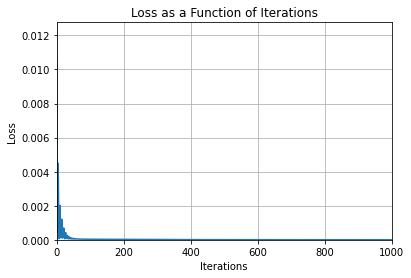

In [179]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec)), loss_vec)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Loss as a Function of Iterations')
ax.set_xlim((0, max_it))
ax.set_ylim((0, max(loss_vec) * 1.2))
plt.grid()
plt.show()

Maybe learn over a random subset of the basis? How to know when finished?